In [2]:
import torch
import torch.nn as nn
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 

In [3]:
DATASET = 'compas'

In [4]:
if DATASET=='income':
    DATASET = 'income'
    SENS_IND = 2
    SENSITIVE_CODE_0 = 0
    SENSITIVE_CODE_1 = 1
    sensitive_value_0 = "male"
    sensitive_value_1 = "female"
    DIRECTORY_PATH = "income_models"
    category_0 = "<=50K"
    category_1 = ">50K"
    sensitive_col_name = "gender_code"
    sensitive = "gender"
    in_columns = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
    out_columns = ['education_code', 'marital_code', 'gender_code', 'occupation_code', 'relationship_code', 'race_code', 'country_code', 'hours_code']

elif DATASET=='compas':
    DATASET = 'compas'
    SENS_IND = 4
    SENSITIVE_CODE_0 = 0
    SENSITIVE_CODE_1 = 1
    sensitive_value_0 = "white"
    sensitive_value_1 = "black"
    DIRECTORY_PATH = "compas_models"
    category_0 = "TL=0"
    category_1 = "TL=1"
    sensitive_col_name = "race_code"
    sensitive = "race"
    in_columns = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid']
    out_columns = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']

In [40]:
column_names = in_columns
in_df = pd.read_csv('adult.data', names=column_names)

In [6]:
column_names = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid']
in_df = pd.read_csv('compas-scores-two-years.csv', names=column_names)

In [7]:
class CustomNetwork(nn.Module):

    # For now the input data is passed as init parameters
    def __init__(self, layer_sizes, itrain, otrain, ival, oval, itrain_raw):
        super(CustomNetwork, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.itrain = itrain
        self.otrain = otrain
        self.ival = ival
        self.oval = oval
        self.itrain_raw = itrain_raw
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.RANDOM_SEED = 0
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [8]:
# Define the directory path where your models are saved
directory_path = DIRECTORY_PATH

# List all the files in the directory
file_list = os.listdir(directory_path)

# Filter files to select only model files (e.g., with '.pt' extension)
model_files = [file for file in file_list if file.endswith('.pth')]

# Create an empty dictionary to store loaded models
loaded_models = []

# Load each model and store it in the dictionary
for model_file in model_files:
    # Extract model name from the file name
    model_name = model_file.split('.')[0]
    
    # Load the model
    model = torch.load(os.path.join(directory_path, model_file), map_location=torch.device('cpu'))
    
    # Add the loaded model to the dictionary
    loaded_models.append((model_file, model))

# Now you can access each model using its name as the key in the loaded_models dictionary
# For example, to access the model named "model1", you can do:
# loaded_models["model1"]

In [38]:
df_raw = pd.read_csv('val_data_'+str(DATASET)+'/val_data_raw_'+str(DATASET)+'.csv')
df_scaled = pd.read_csv('val_data_'+str(DATASET)+'/val_data_scaled_'+str(DATASET)+'.csv')

In [39]:
len(df_raw)

9049

In [10]:
x_raw = df_raw.values[:,:-1]
x_scaled = df_scaled.values[:,:-1]
y = df_scaled.values[:,-1]

In [11]:
def get_auc(predictions, targets):
    predictions = predictions.detach().numpy()
    targets = targets

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr, thresholds 

In [12]:
results_df_pr = pd.DataFrame(columns=['Model', 'AUC_Sensitive_0', 'AUC_Sensitive_1', 'Optimal_Threshold_0', 'Optimal_Threshold_1'])

# Iterate over all models
for model_index, model_iter in enumerate(loaded_models):
    # Set the model to evaluation mode
    (model_name, model) = model_iter
    model.eval()

    # Forward pass for subgroup with sensitive attribute A=0
    with torch.no_grad():
        predictions_0 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

    # Forward pass for subgroup with sensitive attribute A=1
    with torch.no_grad():
        predictions_1 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

    # Calculate AUCs for sensitive attribute 0
    fpr_0, tpr_0, thresholds_0 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], predictions_0)
    auc_0 = auc(fpr_0, tpr_0)

    # Calculate AUCs for sensitive attribute 1
    fpr_1, tpr_1, thresholds_1 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], predictions_1)
    auc_1 = auc(fpr_1, tpr_1)

    auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)

    # Calculate TPR-FPR difference for sensitive attribute 0
    tpr_minus_fpr_0 = tpr_0 - fpr_0
    optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
    optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

    # Calculate TPR-FPR difference for sensitive attribute 1
    tpr_minus_fpr_1 = tpr_1 - fpr_1
    optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
    optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

    # Store results in the DataFrame
    results_df_pr = results_df_pr.append({'Model': str(model_name),
                                    'AUC_Sensitive_0': auc_0,
                                    'AUC_Sensitive_1': auc_1,
                                    'AUC_HM' : auc_hm,
                                    'Optimal_Threshold_0': optimal_threshold_0,
                                    'Optimal_Threshold_1': optimal_threshold_1}, ignore_index=True)

# Display the results DataFrame


/tmp/ipykernel_151719/1819526701.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_pr = results_df_pr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1819526701.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_pr = results_df_pr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1819526701.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_pr = results_df_pr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1819526701.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_pr = results_df_pr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1819526701.py:38: Futu

In [13]:
results_df_pr.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,Optimal_Threshold_0,Optimal_Threshold_1,AUC_HM
20,saved_model19.pth,0.615874,0.700589,0.517560,0.543734,0.327753
14,saved_model2.pth,0.603118,0.692966,0.615077,0.613997,0.322464
10,saved_model12.pth,0.583187,0.699349,0.390754,0.523433,0.318004
12,saved_model14.pth,0.600311,0.659770,0.486114,0.463734,0.314319
13,saved_model9.pth,0.571787,0.655998,0.611898,0.621636,0.305502
16,saved_model13.pth,0.589026,0.609975,0.366040,0.365412,0.299659
2,saved_model20.pth,0.592054,0.586107,0.540693,0.583776,0.294533
15,saved_model4.pth,0.580543,0.588898,0.354660,0.350684,0.292345
11,saved_model1.pth,0.571345,0.584090,0.591432,0.663081,0.288824
17,saved_model3.pth,0.535084,0.607369,0.489636,0.514388,0.284470


In [14]:
results_df_nr = pd.DataFrame(columns=['Model', 'AUC_Sensitive_0', 'AUC_Sensitive_1', 'Optimal_Threshold_0', 'Optimal_Threshold_1', 'AUC_HM'])

# Iterate over all models
for model_index, model_iter in enumerate(loaded_models):
    # Set the model to evaluation mode
    (model_name, model) = model_iter
    model.eval()

    # Forward pass for subgroup with sensitive attribute A=0
    with torch.no_grad():
        predictions_0 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

    # Forward pass for subgroup with sensitive attribute A=1
    with torch.no_grad():
        predictions_1 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

    # Calculate AUCs for sensitive attribute 0 
    fpr_0, tpr_0, thresholds_0 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], predictions_0)
    auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
    tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
    optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
    optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

    # Calculate AUCs for sensitive attribute 1 
    fpr_1, tpr_1, thresholds_1 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], predictions_1)
    auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
    tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
    optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
    optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

    # Find the threshold that maximizes TPR - FPR difference
    

    auc_hm = (auc_0*auc_1)/(auc_0+auc_1)

    # Store results in the DataFrame
    results_df_nr = results_df_nr.append({'Model': str(model_name),
                                          'AUC_Sensitive_0': auc_0,
                                          'AUC_Sensitive_1': auc_1,
                                          'Optimal_Threshold_0': optimal_threshold_0,
                                          'Optimal_Threshold_1': optimal_threshold_1,
                                          'AUC_HM': auc_hm
                                          }, ignore_index=True)


/tmp/ipykernel_151719/1693041805.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_nr = results_df_nr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1693041805.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_nr = results_df_nr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1693041805.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_nr = results_df_nr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1693041805.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_nr = results_df_nr.append({'Model': str(model_name),
/tmp/ipykernel_151719/1693041805.py:37: Futu

In [15]:
results_df_nr.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,Optimal_Threshold_0,Optimal_Threshold_1,AUC_HM
4,saved_model6.pth,0.505193,0.565439,0.457790,0.455019,0.266811
6,saved_model11.pth,0.546915,0.488026,0.516945,0.532038,0.257898
8,saved_model7.pth,0.464038,0.572081,0.662567,0.611417,0.256213
1,saved_model18.pth,0.503947,0.454377,0.455089,0.426243,0.238940
7,saved_model5.pth,0.449484,0.498718,0.729527,0.715557,0.236411
18,saved_model0.pth,0.461910,0.468188,0.409804,0.475506,0.232514
0,saved_model10.pth,0.434605,0.453878,0.572133,0.603295,0.222016
3,saved_model17.pth,0.464033,0.422024,0.594680,0.618538,0.221016
9,saved_model8.pth,0.472301,0.414748,0.539117,0.541774,0.220829
19,saved_model16.pth,0.487023,0.389083,0.476696,0.457756,0.216289


(630, 7)
(954, 7)


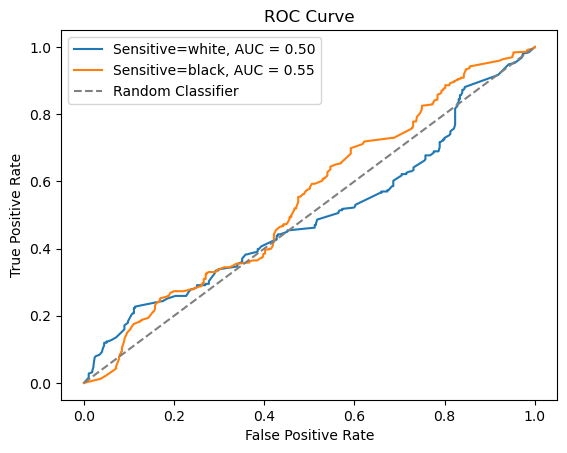

In [16]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
(model_name,model) = loaded_models[1]


# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tpr_minus_fpr = tpr - fpr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Plot the optimal threshold point on the ROC curve
    # if sensitive_value==sensitive_value_1:
    #     plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label=f'Optimal Threshold female = {optimal_threshold:.2f}')
    # if sensitive_value==sensitive_value_0:
    #     plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='blue', marker='o', label=f'Optimal Threshold male = {optimal_threshold:.2f}')

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
with torch.no_grad():
    print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :].shape)
    predictions_0 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
with torch.no_grad():
    print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :].shape)
    predictions_1 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve_pr(predictions_0, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], sensitive_value=sensitive_value_0)

# Plot ROC for sensitive attribute A=1
plot_roc_curve_pr(predictions_1, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], sensitive_value=sensitive_value_1)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

(6099, 8)
(2950, 8)
0.3604323422083897
0.4243908846529814


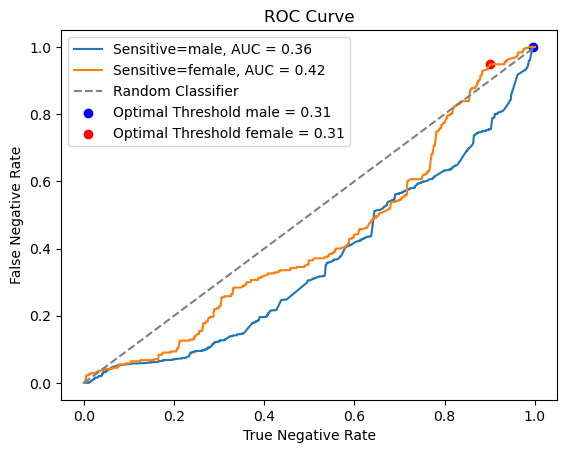

In [17]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
(model_name,model) = loaded_models[0]


# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)

    print(roc_auc)

    # Plot ROC curve
    plt.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = fnr - tnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Plot the optimal threshold point on the ROC curve
    if sensitive_value==sensitive_value_1:
        plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='red', marker='o', label=f'Optimal Threshold female = {optimal_threshold:.2f}')
    if sensitive_value==sensitive_value_0:
        plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='blue', marker='o', label=f'Optimal Threshold male = {optimal_threshold:.2f}')

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
with torch.no_grad():
    print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :].shape)
    predictions_0 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
with torch.no_grad():
    print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :].shape)
    predictions_1 = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve_nr(predictions_0, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], sensitive_value=sensitive_value_0)

# Plot ROC for sensitive attribute A=1
plot_roc_curve_nr(predictions_1, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], sensitive_value=sensitive_value_1)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('True Negative Rate')
plt.ylabel('False Negative Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

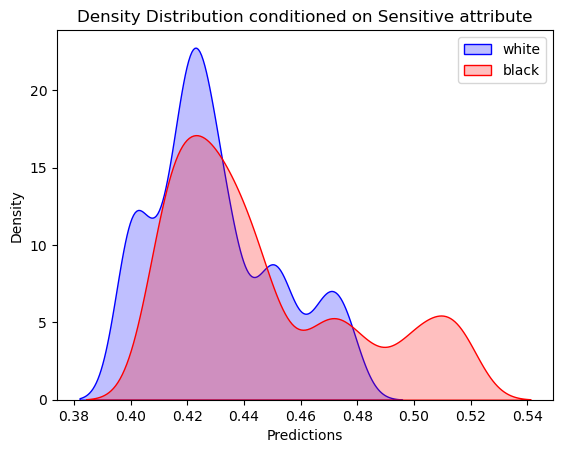

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

(model_name,model) = loaded_models[1]

# Assuming you have predictions for male and female
predictions_0_tensor = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
predictions_1_tensor = model(torch.Tensor(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Convert predictions tensors to numpy arrays
predictions_0 = predictions_0_tensor.detach().numpy()
predictions_1 = predictions_1_tensor.detach().numpy()

# Create density distribution plot
sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True)
sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True)

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Density')
plt.title('Density Distribution conditioned on Sensitive attribute')

# Show legend
plt.legend()

# Show plot
plt.show()

In [18]:
thresholds = np.linspace(0.44, 0.46, 20)
acc_values = []
fpr_sensitive_1_values = []
tpr_sensitive_1_values = []
fpr_sensitive_0_values = []
tpr_sensitive_0_values = []
fnr_sensitive_1_values = []
tnr_sensitive_1_values = []
fnr_sensitive_0_values = []
tnr_sensitive_0_values = []
neg_precision_sensitive_0_values = []
neg_precision_sensitive_1_values = []
precision_sensitive_0_values = []
precision_sensitive_1_values = []

for thresh in thresholds:
    outputs = model.forward(torch.Tensor(x_scaled))
    predictions = (outputs >= thresh).float()

    true = y

    df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
    df_out["pred_labels"] = np.array(predictions).astype(int)
    df_out["true_labels"] = np.array(true).astype(int)

    acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]]) / len(df_out)
    acc_values.append(acc)

    # True Positives, False Positives, True Negatives, False Negatives
    tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['gender_code'] == SENSITIVE_CODE_1)])
    fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['gender_code'] == SENSITIVE_CODE_1)])
    tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['gender_code'] == SENSITIVE_CODE_1)])
    fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['gender_code'] == SENSITIVE_CODE_1)])

    tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['gender_code'] == SENSITIVE_CODE_0)])
    fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['gender_code'] == SENSITIVE_CODE_0)])
    tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['gender_code'] == SENSITIVE_CODE_0)])
    fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['gender_code'] == SENSITIVE_CODE_0)])

    # Additional calculations
    fpr_sensitive_1 = fp_sensitive_1 / (fp_sensitive_1 + tn_sensitive_1) 
    tpr_sensitive_1 = tp_sensitive_1 / (tp_sensitive_1 + fn_sensitive_1) 
    fpr_sensitive_0 = fp_sensitive_0 / (fp_sensitive_0 + tn_sensitive_0) 
    tpr_sensitive_0 = tp_sensitive_0 / (tp_sensitive_0 + fn_sensitive_0) 

    fnr_female = tn_sensitive_1 / (fn_sensitive_1 + tp_sensitive_1) 
    tnr_female = tn_sensitive_1 / (tn_sensitive_1 + fp_sensitive_1)
    fnr_male = fn_sensitive_0 / (fn_sensitive_0 + tp_sensitive_0) 
    tnr_male = tn_sensitive_0 / (tn_sensitive_0 + fp_sensitive_0)

    fpr_sensitive_1_values.append(fpr_sensitive_1)
    tpr_sensitive_1_values.append(tpr_sensitive_1)
    fpr_sensitive_0_values.append(fpr_sensitive_0)
    tpr_sensitive_0_values.append(tpr_sensitive_0)

    fnr_sensitive_1_values.append(fnr_female)
    tnr_sensitive_1_values.append(tnr_female)
    fnr_sensitive_0_values.append(fnr_male)
    tnr_sensitive_0_values.append(tnr_male)

    neg_precision_male = tn_sensitive_0/(tn_sensitive_0 + fn_sensitive_0)
    neg_precision_female = tn_sensitive_1/(tn_sensitive_1 + fn_sensitive_1)
    precision_male = tp_sensitive_0/(tp_sensitive_0 + fp_sensitive_0)
    precision_female = tp_sensitive_1/(tp_sensitive_1 + fp_sensitive_1)

    neg_precision_sensitive_1_values.append(neg_precision_female)
    neg_precision_sensitive_0_values.append(neg_precision_male)
    precision_sensitive_1_values.append(precision_female)
    precision_sensitive_0_values.append(precision_male)
    


In [19]:
data = {
    'thresh' : thresholds,
    'acc': acc_values, 
    'fpr_'+str(sensitive_value_1): fpr_sensitive_1_values,
    'tpr_'+str(sensitive_value_1): tpr_sensitive_1_values,
    'fpr_'+str(sensitive_value_0): fpr_sensitive_0_values,
    'tpr_'+str(sensitive_value_0): tpr_sensitive_0_values,
    'fnr_'+str(sensitive_value_1): fnr_sensitive_1_values,
    'tnr_'+str(sensitive_value_1): tnr_sensitive_1_values,
    'fnr_'+str(sensitive_value_0): fnr_sensitive_0_values,
    'tnr_'+str(sensitive_value_0): tnr_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1_values,
    'precision_'+str(sensitive_value_0): precision_sensitive_0_values,
    'precision_'+str(sensitive_value_1): precision_sensitive_1_values
}

# Create DataFrame
plot_df = pd.DataFrame(data)

In [20]:
plot_df.sort_values(by='acc')

,thresh,acc,fpr_black,tpr_black,fpr_white,tpr_white,fnr_black,tnr_black,fnr_white,tnr_white,neg_precision_white,neg_precision_black,precision_white,precision_black
1,0.441053,0.517677,0.322531,0.349131,0.448454,0.486239,0.693523,0.677469,0.513761,0.551546,0.656442,0.515864,0.378571,0.513953
5,0.445263,0.517677,0.304012,0.328594,0.412371,0.431193,0.712480,0.695988,0.568807,0.587629,0.647727,0.514840,0.370079,0.513580
6,0.446316,0.518308,0.302469,0.328594,0.386598,0.385321,0.714060,0.697531,0.614679,0.613402,0.639785,0.515393,0.358974,0.514851
3,0.443158,0.518308,0.310185,0.336493,0.438144,0.477064,0.706161,0.689815,0.522936,0.561856,0.656627,0.515571,0.379562,0.514493
4,0.444211,0.518939,0.305556,0.330174,0.417526,0.458716,0.710900,0.694444,0.541284,0.582474,0.656977,0.514874,0.381679,0.513514
2,0.442105,0.519571,0.311728,0.339652,0.438144,0.486239,0.704581,0.688272,0.513761,0.561856,0.660606,0.516204,0.384058,0.515588
0,0.440000,0.530303,0.333333,0.391785,0.453608,0.495413,0.682464,0.666667,0.504587,0.546392,0.658385,0.528764,0.380282,0.534483
7,0.447368,0.530303,0.271605,0.322275,0.360825,0.366972,0.745656,0.728395,0.633028,0.639175,0.642487,0.523862,0.363636,0.536842
8,0.448421,0.530303,0.268519,0.317536,0.324742,0.311927,0.748815,0.731481,0.688073,0.675258,0.635922,0.523179,0.350515,0.536000
9,0.449474,0.539141,0.256173,0.317536,0.288660,0.302752,0.761453,0.743827,0.697248,0.711340,0.644860,0.527352,0.370787,0.547684


In [21]:
plot_df['net_pres_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['precision_'+str(sensitive_value_0)]
plot_df['net_pres_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['precision_'+str(sensitive_value_1)]

In [22]:
plot_df['F1_'+str(sensitive_value_0)] = plot_df['precision_'+str(sensitive_value_0)]*plot_df['tpr_'+str(sensitive_value_0)]/(plot_df['precision_'+str(sensitive_value_0)] + plot_df['tpr_'+str(sensitive_value_0)])
plot_df['F1_'+str(sensitive_value_1)] = plot_df['precision_'+str(sensitive_value_1)]*plot_df['tpr_'+str(sensitive_value_1)]/(plot_df['precision_'+str(sensitive_value_1)] + plot_df['tpr_'+str(sensitive_value_1)])

In [23]:
plot_df['neg_F1_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['tnr_'+str(sensitive_value_0)]/(plot_df['neg_precision_'+str(sensitive_value_0)] + plot_df['tnr_'+str(sensitive_value_0)])
plot_df['neg_F1_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['tnr_'+str(sensitive_value_1)]/(plot_df['neg_precision_'+str(sensitive_value_1)] + plot_df['tnr_'+str(sensitive_value_1)])

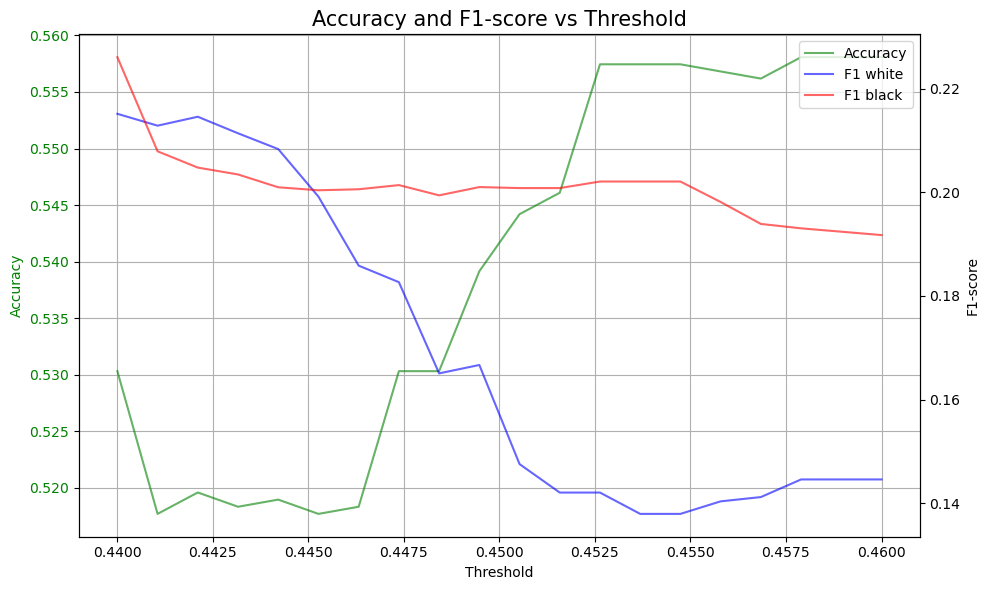

In [24]:
import matplotlib.pyplot as plt

# Your DataFrame plot_df
# Assuming plot_df contains columns: 'thresh', 'acc', 'net_pres_male', 'net_pres_female'

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase the figure size

# Plotting accuracy on the left y-axis
color = 'green'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(plot_df['thresh'], plot_df['acc'], label='Accuracy', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for precision
ax2 = ax1.twinx()

# Plotting precision on the right y-axis
#color = 'red'
ax2.set_ylabel('F1-score')
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_0)], label='F1 '+str(sensitive_value_0), color='blue', alpha=0.6)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_1)], label='F1 '+str(sensitive_value_1), color='red', alpha=0.6)
ax2.tick_params(axis='y')

# Title and legend
plt.title('Accuracy and F1-score vs Threshold', fontsize=15)

# Adjusting legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Grid
ax1.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [25]:
(model_name,model) = loaded_models[1]
outputs = model.forward(torch.Tensor(x_scaled))
predictions = (outputs >= 0.446).float()
true = y

In [26]:
############  FOR INCOME  #############
df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [27]:
# ############ FOR COMPAS ############
# df_out = pd.DataFrame(np.array(x_raw), columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid'])
# df_out["pred_labels"] = np.array(predictions).astype(int)
# df_out["true_labels"] = np.array(true).astype(int)

In [28]:
acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]])/len(df_out)
print(acc)

0.5176767676767676


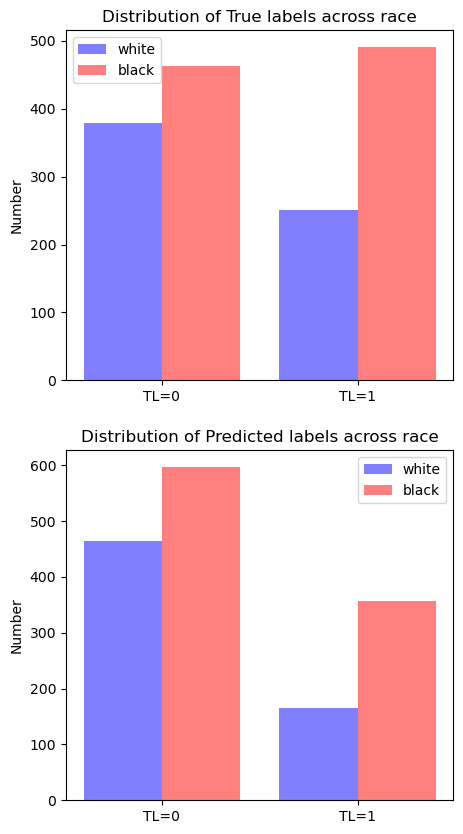

In [29]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = [category_0, category_1]
values1 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 1)])]
values2 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
ax[0].set_title("Distribution of True labels across "+ str(sensitive))
ax[0].legend()


categories2 = [category_0, category_1]
values3 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 1)])]
values4 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
ax[1].set_title("Distribution of Predicted labels across "+str(sensitive))
ax[1].legend()

In [30]:
tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

In [31]:
fpr_sensitive_1 = fp_sensitive_1/(fp_sensitive_1 + tn_sensitive_1)
tpr_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fn_sensitive_1)
fpr_sensitive_0 = fp_sensitive_0/(fp_sensitive_0 + tn_sensitive_0)
tpr_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fn_sensitive_0)

fnr_sensitive_1 = fn_sensitive_1/(fn_sensitive_1 + tp_sensitive_1)
tnr_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fp_sensitive_1)
fnr_sensitive_0 = fn_sensitive_0/(fn_sensitive_0 + tp_sensitive_0)
tnr_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fp_sensitive_0)

In [32]:
print(fnr_sensitive_1)
print(tnr_sensitive_1)
print(fnr_sensitive_0)
print(tnr_sensitive_0)

0.6354378818737271
0.6155507559395248
0.7171314741035857
0.7519788918205804


In [33]:
print(fpr_sensitive_1)
print(tpr_sensitive_1)
print(fpr_sensitive_0)
print(tpr_sensitive_0)

0.38444924406047515
0.3645621181262729
0.24802110817941952
0.28286852589641437


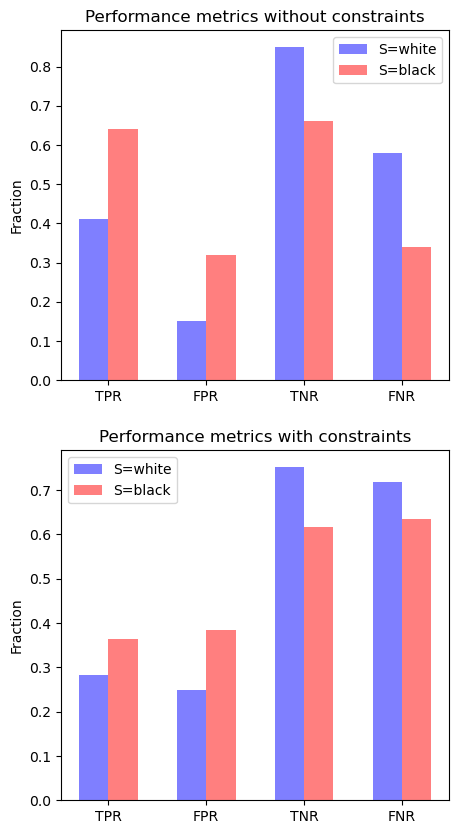

In [36]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['TPR', 'FPR', 'TNR', 'FNR']
values1 = [0.41, 0.15, 0.85, 0.58]
values2 = [0.64, 0.32, 0.66, 0.34]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Fraction")
ax[0].set_title('Performance metrics without constraints')
ax[0].legend()


categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
values3 = [tpr_sensitive_0, fpr_sensitive_0, tnr_sensitive_0, fnr_sensitive_0]
values4 = [tpr_sensitive_1, fpr_sensitive_1, tnr_sensitive_1, fnr_sensitive_1]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Fraction")
ax[1].set_title('Performance metrics with constraints')
ax[1].legend()
